# Introduction
This project analyses a data-jobs dataset from Kaggle to uncover salary trends, in-demand skills, and role expectations across the data industry around the world. It also features a predictive model that allows users to “name their personal price” by entering their target role, skills, company location, and experience to estimate a realistic market-aligned salary range for better career planning and negotiation.

# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import requests

import xgboost as xgb
from xgboost import XGBRegressor # Main model for this prediction

import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType # Save model for site

import json # Save columns names for onnx

In [2]:
full_df = pd.read_csv('data_science_job_posts_2025.csv')
full_df.info()
full_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        941 non-null    object
 1   seniority_level  884 non-null    object
 2   status           688 non-null    object
 3   company          944 non-null    object
 4   location         942 non-null    object
 5   post_date        944 non-null    object
 6   headquarter      944 non-null    object
 7   industry         944 non-null    object
 8   ownership        897 non-null    object
 9   company_size     944 non-null    object
 10  revenue          929 non-null    object
 11  salary           944 non-null    object
 12  skills           944 non-null    object
dtypes: object(13)
memory usage: 96.0+ KB


,job_title,seniority_level,status,company,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
0,data scientist,senior,hybrid,company_003,"Grapevine, TX . Hybrid",17 days ago,"Bentonville, AR, US",Retail,Public,€352.44B,Public,"€100,472 - €200,938","['spark', 'r', 'python', 'scala', 'machine lea..."
1,data scientist,lead,hybrid,company_005,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030",€51.10B,"€118,733","['spark', 'r', 'python', 'sql', 'machine learn..."


# Cleaning
Some key factors that are important to spot out the range include job title, seniority level, location (country-based or continent-based for generalised data), industry, ownership, company size and skill set of candidates.
- Omit observations with null value for job title, which is one of the crucial factors (only 3 observations removed)
- Assign mid level for seniority level for null spots
- Using headquarter to extract the country based and map them to continent data
- Salary column will be divided into starting point and ending point and be converted into AUD
- Skills will be separated into single column for each of them, can be combined later based on the type of skills
- Others will be deleted

### Remove some unwanted columns

In [3]:
df = full_df.drop(columns=["company", "location", "post_date", "revenue", "company_size"])

### Dealing with null value in job title and seniority level
In terms of job title, due to the significant gap between among titles, this model mainly will focus on position data scientist and machine learning engineer. Although the number of machine learning engineer observations is overshadowed, there are still chances to get it train properly while doing random splitting. The result might be skewed biased towards data scientist observations.

Moreover, regarding to seniority level, there are also gaps among levels. As a result, all null value will be assigned with the junior level.

In [4]:
df['job_title'].value_counts(dropna=False)

job_title
data scientist               856
machine learning engineer     80
data engineer                  4
NaN                            3
data analyst                   1
Name: count, dtype: int64

In [5]:
df = df[df['job_title'].isin(['data scientist', 'machine learning engineer'])]
df = df.dropna(subset = ['job_title'])

In [6]:
df['seniority_level'].value_counts(dropna=False)

seniority_level
senior      626
lead        115
midlevel    110
NaN          60
junior       25
Name: count, dtype: int64

In [7]:
seniority_map = {
    'junior': 1,
    'midlevel': 2,
    'senior': 3,
    'lead': 4
}

df['seniority_level'] = df['seniority_level'].map(seniority_map)
df['seniority_level'] = df['seniority_level']

### Mapping to continent

In [8]:
df['country'] = df['headquarter'].str[-2:]
print(df['country'].value_counts())

country
US    765
IN     27
IE     22
GB     22
CA     22
FR     14
DE     11
SG     10
CH      7
NL      7
EE      6
CN      4
DK      4
TW      3
SE      3
AU      3
IT      2
BR      1
AT      1
JP      1
ES      1
Name: count, dtype: int64


There are a lot of observation with the quantity less than 10. Hence, because those locations exist but dont have any clear reliable pattern, I'll treat them as general non-major markets, which will be considered **'Others'** in the continent column.

So now in the continent columns, we will only have North America, Europe, Asia, and Others.

Moreover, due to the extreme value of the US market, another column named **isUS** will be added, which could balance the data and give some insights among other countries.

In [9]:
# Mapping to continent
continent_map = {
    'US': 'North America',
    'CA': 'North America',
    'GB': 'Europe',
    'DE': 'Europe',
    'FR': 'Europe',
    'IE': 'Europe',
    'IN': 'Asia',
    'SG': 'Asia'
}

df['continent'] = df['country'].map(continent_map).fillna('Others')
df = df.drop(columns = ['headquarter'])

### Dividing salary to starting and ending points

In [10]:
def get_exchange_rate(from_currency='EUR', to_currency='AUD'):
    url = f"https://api.frankfurter.app/latest?from={from_currency}&to={to_currency}"
    response = requests.get(url)
    data = response.json()
    return data['rates'][to_currency]

In [11]:
def addSalaryRange(colRange, exchange_rate = get_exchange_rate()):
    # Remove currency and commas
    cleanRange = colRange.replace('€', '').replace(',', '').strip()

    # Split column and convert to AUD
    if '-' in cleanRange:
        start, end = cleanRange.split('-')
        start = float(start.strip()) * exchange_rate
        end   = float(end.strip()) * exchange_rate
    else: 
        start = end = float(cleanRange) * exchange_rate

    return pd.Series([start, end])

In [12]:
df[['salary_start_aud', 'salary_end_aud']] = df['salary'].apply(addSalaryRange)
df['range_log'] = np.log1p(df['salary_end_aud'] - df['salary_start_aud']) # Can give more information
df = df.drop(columns=["salary"])

### Separating skills

In [13]:
def cleanSkills(skills): # Need to transform it to list type, to work with MultiLabelBinarizer
    cleanSkills = skills.replace('[','').replace(']','').replace("'",'')
    if cleanSkills == '':
        return ['None'] #### Later just need to remove the column named 'None'
    cleanSkills = cleanSkills.split(', ')
    return cleanSkills

df['skills'] = df['skills'].apply(cleanSkills)

In [14]:
skills_list = []

for lists in df['skills']:
    for listX in lists:
        if listX not in skills_list: skills_list.append(listX)

mlb = MultiLabelBinarizer(classes = skills_list)
skills_df = pd.DataFrame(mlb.fit_transform(df['skills']), columns = skills_list)

## Remove None
skills_df = skills_df.drop(columns = ['None'])
skills_list.remove('None')

### Creating dummy instead of categorical data

In [15]:
df = pd.get_dummies(df,
                    columns = ['job_title', 'status', 'industry', 'ownership', 'continent', 'country'],
                    dummy_na = False, ## XGBoost can work with null value
                    drop_first = False, 
                    dtype = int).drop(columns = ['skills'])

### Concatenate everything together

In [16]:
detailed_df = pd.concat([df.reset_index(drop=True), skills_df.reset_index(drop=True)], axis=1)

## Only keep 90% of dataset
detailed_df = detailed_df[
    (detailed_df['salary_start_aud'] >= detailed_df['salary_start_aud'].quantile(0.01)) &
    (detailed_df['salary_start_aud'] <= detailed_df['salary_start_aud'].quantile(0.99))
]

# Model build

## Using table with detailed skills 

In [17]:
X = detailed_df.drop(columns=["salary_start_aud", "salary_end_aud"]).reset_index(drop=True)
y = detailed_df[["salary_start_aud", "salary_end_aud"]].reset_index(drop=True)
y_log = np.log1p(y) # Mainly used due to big variance when working with money data

X_train, X_test, y_train, y_test = train_test_split(X, y_log,
                                                    test_size = 0.2,
                                                    random_state = 412,
                                                    shuffle = True)

#### Starting point

In [18]:
xgb_start = XGBRegressor()

param_grid = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1], 
    'reg_alpha': [0, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

random_search_start = RandomizedSearchCV(estimator = xgb_start,
                                         param_distributions = param_grid,
                                         n_iter = 50, scoring = 'r2', cv = 5)

random_search_start.fit(X_train, y_train["salary_start_aud"])

model_start = random_search_start.best_estimator_
model_start.fit(X_train, y_train["salary_start_aud"])

y_pred_start = model_start.predict(X_test)

In [19]:
tab_start = pd.DataFrame({'actual_salary': np.expm1(y_test["salary_start_aud"]),
                          'prediction_salary': np.expm1(y_pred_start),
                          'error_salary': np.expm1(y_test["salary_start_aud"]) - np.expm1(y_pred_start),
                          'abs%_error': abs(np.expm1(y_test["salary_start_aud"]) - np.expm1(y_pred_start)) / np.expm1(y_test["salary_start_aud"]),
                          'actual_log': y_test["salary_start_aud"],
                          'prediction_log': y_pred_start})

#### Ending point

In [20]:
xgb_end = XGBRegressor()

param_grid = { # Expect to gain deeper pattern compared to starting range
    'n_estimators': [1000, 1200, 1500],
    'max_depth': [7, 8, 9, 10, 12],
    'learning_rate': [0.01, 0.02, 0.05], 
    'reg_alpha': [0, 0.01, 0.05, 0.1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.2, 0.5, 1]
}

random_search_end = RandomizedSearchCV(estimator = xgb_end, 
                                       param_distributions = param_grid,
                                       n_iter = 50, scoring = 'r2', cv = 5)

random_search_end.fit(X_train, y_train["salary_end_aud"])

model_end = random_search_end.best_estimator_
model_end.fit(X_train, y_train["salary_end_aud"])

y_pred_end = model_end.predict(X_test)

In [21]:
tab_end = pd.DataFrame({'actual_salary': np.expm1(y_test["salary_end_aud"]),
                        'prediction_salary': np.expm1(y_pred_end),
                        'error_salary': np.expm1(y_test["salary_end_aud"]) - np.expm1(y_pred_end),
                        'abs%_error': abs(np.expm1(y_test["salary_end_aud"]) - np.expm1(y_pred_end)) / np.expm1(y_test["salary_end_aud"]),
                        'actual_log': y_test["salary_end_aud"],
                        'prediction_log': y_pred_end})

### Analysis

#### Model assessment

In [22]:
r2_start = r2_score(tab_start['actual_log'], tab_start['prediction_log'])
r2_end   = r2_score(tab_end['actual_log'], tab_end['prediction_log'])

print('Model explains', round(r2_start * 100, 2), 'percent of the variation in starting salary')
print('Model explains', round(r2_end * 100, 2), 'percent of the variation in ending salary')

Model explains 64.14 percent of the variation in starting salary
Model explains 72.33 percent of the variation in ending salary


With **majority of the variation in salary ranges explained**, the model demonstrates moderate predictive performance. This suggests that key factors such as job role, experience, location, and skill sets are meaningful drivers in capturing salary patterns within the data. 

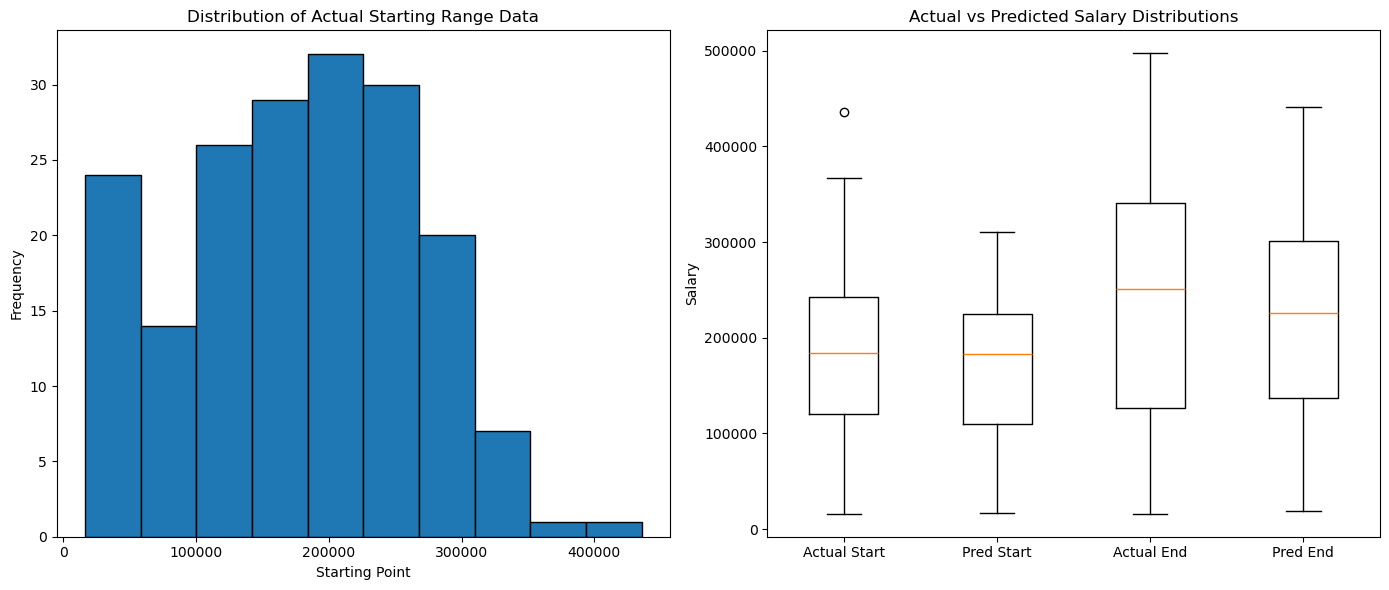

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Distribution of Actual Starting Range Data
axes[0].hist(np.expm1(y_test["salary_start_aud"]), edgecolor='black')
axes[0].set_title("Distribution of Actual Starting Range Data")
axes[0].set_xlabel("Starting Point")
axes[0].set_ylabel("Frequency")

# Boxplot of Actual vs Predicted Salary Distributions
axes[1].boxplot([tab_start['actual_salary'], tab_start['prediction_salary'], 
                 tab_end['actual_salary'], tab_end['prediction_salary']],
                 tick_labels=['Actual Start', 'Pred Start', 'Actual End', 'Pred End'])
axes[1].set_title("Actual vs Predicted Salary Distributions")
axes[1].set_ylabel("Salary")

plt.tight_layout()
plt.show()

The boxplot indicates that the model successfully captures the bulk of the salary distribution, as **most predicted values fall within the interquartile range** of the actual data. This suggests that the model generalises well for typical cases.

However, the model struggles with higher salary ranges, where a few observations are under-predicted compared to the actual values. This is likely due to the imbalance in the original dataset — only two job postings have starting salaries around $400,000 — so **the model lacks sufficient examples to confidently predict extreme values**.

In [24]:
tab_start['error_band'] = pd.cut(
    tab_start['abs%_error'],
    bins=[0, 0.3, 1],
    labels=['Less than 30%', 'More than 30%']
)

tab_end['error_band'] = pd.cut(
    tab_end['abs%_error'],
    bins=[0, 0.3, 1],
    labels=['Less than 30%', 'More than 30%']
)

print('Starting salary prediction accuracy:')
print(tab_start['error_band'].value_counts(normalize=True)*100)

print('\nEnding salary prediction accuracy:')
print(tab_end['error_band'].value_counts(normalize=True)*100)

Starting salary prediction accuracy:
error_band
Less than 30%    78.034682
More than 30%    21.965318
Name: proportion, dtype: float64

Ending salary prediction accuracy:
error_band
Less than 30%    81.609195
More than 30%    18.390805
Name: proportion, dtype: float64


**Most salary predictions fall within 30%** of the actual salary values, indicating that the model provides **reasonably reliable estimates** for the majority of job postings. This approach offers a more intuitive and practical assessment of performance, reflecting how the model may be **used in real-world salary benchmarking and career planning**.

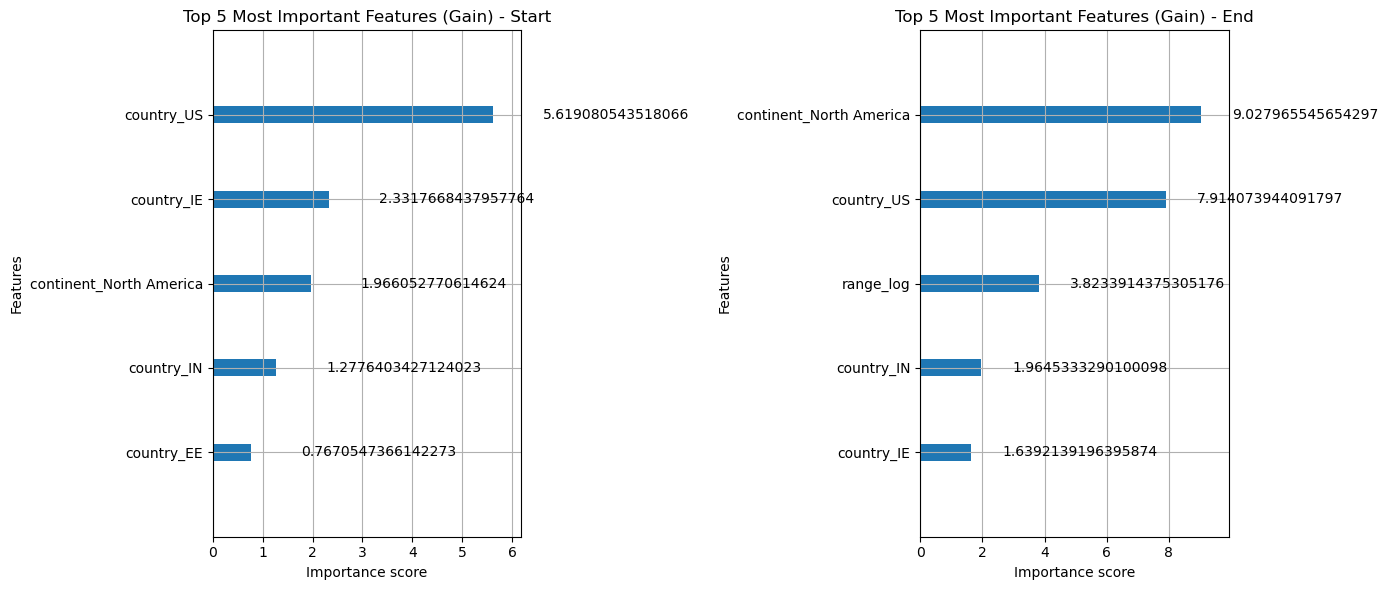

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Gain - start
xgb.plot_importance(model_start, max_num_features = 5, importance_type = 'gain', ax = axes[0])
axes[0].set_title("Top 5 Most Important Features (Gain) - Start")

# Gain - end
xgb.plot_importance(model_end, max_num_features = 5, importance_type = 'gain', ax = axes[1])
axes[1].set_title("Top 5 Most Important Features (Gain) - End")

plt.tight_layout()
plt.show()

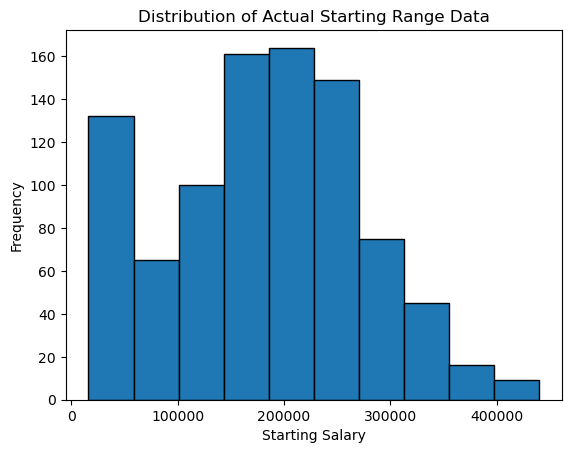

In [26]:
plt.hist(detailed_df['salary_start_aud'], edgecolor='black')
plt.xlabel("Starting Salary")
plt.ylabel("Frequency")
plt.title("Distribution of Actual Starting Range Data")
plt.show()

There are 749 posts from the US company in 916


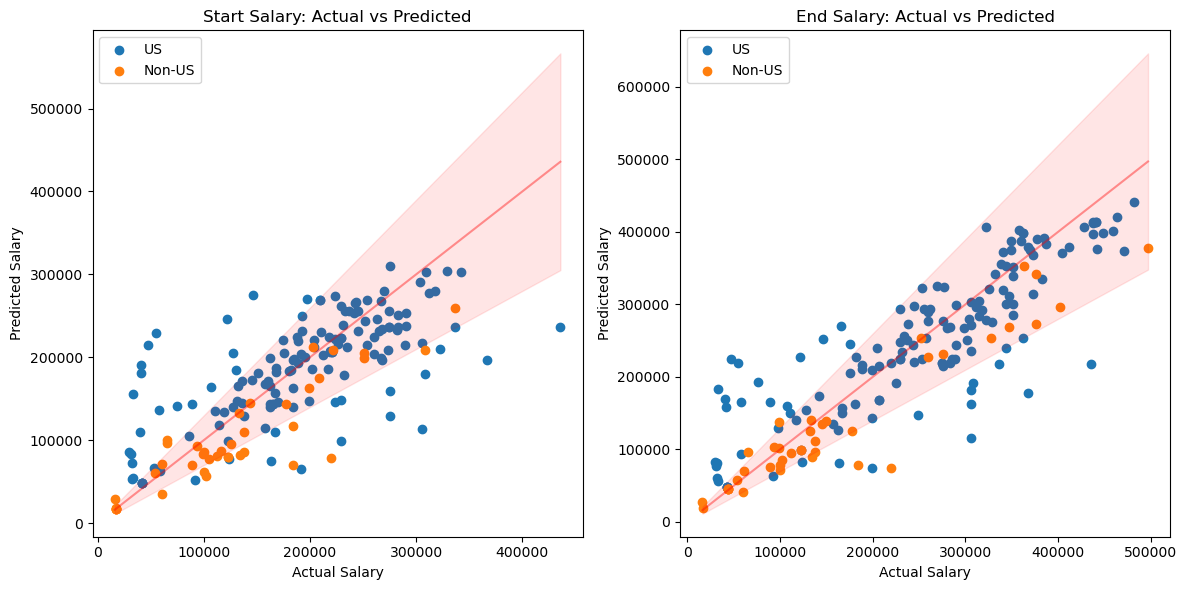

In [27]:
print('There are', sum(detailed_df['country_US'] == 1), 'posts from the US company in', len(detailed_df))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

us_mask = X_test['country_US'] == 1
non_us_mask = X_test['country_US'] == 0

# Starting range graph
ax = axes[0]
ax.scatter(tab_start.loc[us_mask, 'actual_salary'], 
           tab_start.loc[us_mask, 'prediction_salary'],
           label = 'US')
ax.scatter(tab_start.loc[non_us_mask, 'actual_salary'], 
           tab_start.loc[non_us_mask, 'prediction_salary'],
           label = 'Non-US')
ax.legend()

# Line of perfect prediction
min_val = min(np.min(tab_start['actual_salary']), np.min(tab_start['prediction_salary']))
max_val = max(np.max(tab_start['actual_salary']), np.max(tab_start['prediction_salary']))
ax.plot([min_val, max_val], [min_val, max_val], color = 'red', alpha = 0.4)

ax.fill_between([min_val, max_val],
    [min_val*0.7, max_val*0.7],
    [min_val*1.3, max_val*1.3],
    color = 'red', alpha = 0.1)

ax.set_xlabel("Actual Salary")
ax.set_ylabel("Predicted Salary")
ax.set_title("Start Salary: Actual vs Predicted")

# Ending range graph
ax = axes[1]
ax.scatter(tab_end.loc[us_mask, 'actual_salary'], 
           tab_end.loc[us_mask, 'prediction_salary'],
           label = 'US')
ax.scatter(tab_end.loc[non_us_mask, 'actual_salary'], 
           tab_end.loc[non_us_mask, 'prediction_salary'],
           label = 'Non-US')
ax.legend()

# Line of perfect prediction
min_val = min(np.min(tab_end['actual_salary']), np.min(tab_end['prediction_salary']))
max_val = max(np.max(tab_end['actual_salary']), np.max(tab_end['prediction_salary']))
ax.plot([min_val, max_val], [min_val, max_val], color = 'red', alpha = 0.4)

ax.fill_between([min_val, max_val],
    [min_val*0.7, max_val*0.7],
    [min_val*1.3, max_val*1.3],
    color = 'red', alpha = 0.1)

ax.set_xlabel("Actual Salary")
ax.set_ylabel("Predicted Salary")
ax.set_title("End Salary: Actual vs Predicted")

plt.tight_layout()
plt.show()

Visually, the scatter plots illustrate how many observations fall within the 30% error band. Overall, more than 75% of the predictions lie within this region, indicating that both models demonstrate reasonably strong predictive performance. However, several notable errors remain and can be explained by characteristics of the dataset.

Consistent with the boxplot results, only a small number of observations (out of more than 900 samples) represent very high salary ranges. This limited representation makes it challenging for the models to learn reliable patterns for these cases, leading to a tendency to underpredict high-salary positions.

Conversely, a number of lower-salary observations are overpredicted. The dataset is heavily dominated by US job postings (749 out of 916), with salaries largely concentrated in the mid-to-high ranges. As a result, features such as **country_US** and **continent_North America** (in top 5 features with great importance to models) become strong predictive signals, and the models may bias predictions toward higher salary levels when these features are present.

These limitations are primarily data-related rather than model-related. Performance could be further improved by collecting more balanced data across regions and salary levels, particularly for non-US markets and lower-paying roles. Nevertheless, the current models still provide sufficiently reliable estimates for practical use, such as helping job seekers approximate their expected salary range when “naming their price.”

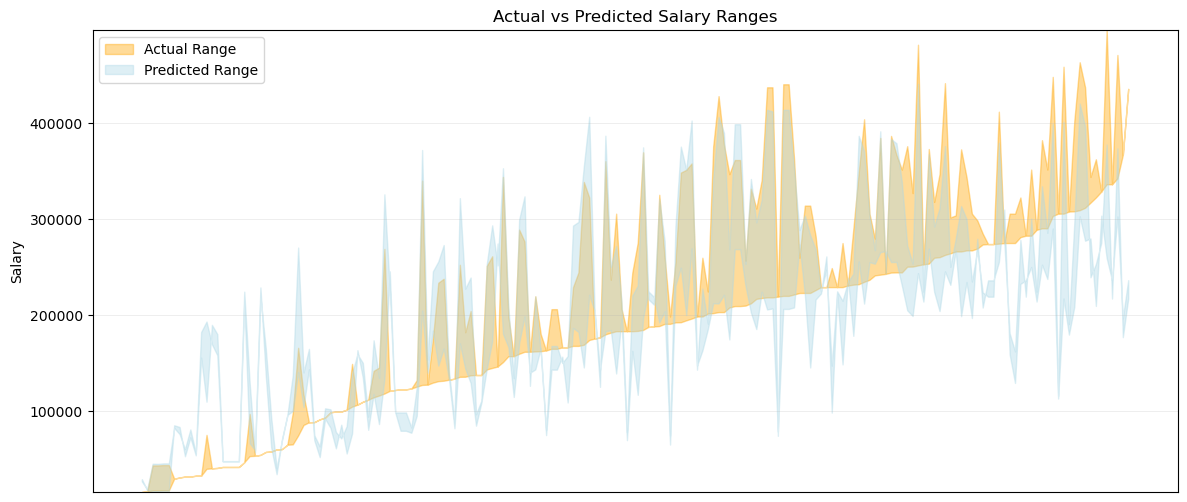

In [28]:
df_plot = pd.DataFrame({
    'actual_start': tab_start['actual_salary'],
    'actual_end': tab_end['actual_salary'],
    'pred_start': tab_start['prediction_salary'],
    'pred_end': tab_end['prediction_salary']
})

# Sorted by actual starting point (Clear visualisation for range)
df_plot = df_plot.sort_values(by='actual_start').reset_index(drop=True)

idx = range(len(df_plot))

plt.figure(figsize=(14,6))

# Actual salary range
plt.fill_between(idx, df_plot['actual_start'], df_plot['actual_end'], 
                 color = 'orange', alpha = 0.4, label = 'Actual Range')

# Predicted salary range
plt.fill_between(idx, df_plot['pred_start'], df_plot['pred_end'], 
                 color = 'lightblue', alpha = 0.4, label = 'Predicted Range')

plt.title("Actual vs Predicted Salary Ranges")
plt.ylabel("Salary")
plt.ylim(min(df_plot.min()), max(df_plot.max()))
plt.xticks([])
plt.legend()
plt.grid(True, linestyle = '-', alpha = 0.3, lw = 0.5)
plt.show()

Finally, this graph shows how the predicted salaries compare to the actual ranges. Similar to the previous plots, the overlapping points are concentrated primarily in the mid-range, roughly between $\textdollar$120,000 and $\textdollar$300,000. Predictions in this range align closely with actual salaries, indicating that the model is most confident here. At the lower and higher extremes, predictions are more dispersed, reflecting the limited number of examples and higher uncertainty in these regions. Overall, this suggests the model performs reliably for typical mid-range salaries, which is enough for users to rely on as a foundation when trying to negotiate salary band in the future.


# Save model to create site for user-friendly interaction

In [29]:
X_train_np = X_train.values.astype(np.float32)

# Retrain
model_start = random_search_start.best_estimator_
model_start.fit(X_train_np, y_train["salary_start_aud"])

model_end = random_search_end.best_estimator_
model_end.fit(X_train_np, y_train["salary_end_aud"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [30]:
feature_order = list(X_train.columns)
n_features = X_train_np.shape[1]
initial_type = [('input', FloatTensorType([None, n_features]))]

onnx_start = onnxmltools.convert_xgboost(model_start.get_booster(), initial_types=initial_type)
onnx_end = onnxmltools.convert_xgboost(model_end.get_booster(), initial_types=initial_type)

with open("salary_start_model.onnx", "wb") as f:
    f.write(onnx_start.SerializeToString())

with open("salary_end_model.onnx", "wb") as f:
    f.write(onnx_end.SerializeToString())

with open("feature_order.json", "w") as f:
    json.dump(feature_order, f)